<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Getting-Started-with-Time-Series-Analysis" data-toc-modified-id="Getting-Started-with-Time-Series-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Getting Started with Time Series Analysis</a></span><ul class="toc-item"><li><span><a href="#Averages" data-toc-modified-id="Averages-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Averages</a></span></li><li><span><a href="#Exponential-Smoothing" data-toc-modified-id="Exponential-Smoothing-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Exponential Smoothing</a></span></li><li><span><a href="#Double-Exponential-Smoothing---Holt-Method" data-toc-modified-id="Double-Exponential-Smoothing---Holt-Method-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Double Exponential Smoothing - Holt Method</a></span></li><li><span><a href="#Triple-Exponential-Smoothing---Holt-Winters-Method" data-toc-modified-id="Triple-Exponential-Smoothing---Holt-Winters-Method-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Triple Exponential Smoothing - Holt-Winters Method</a></span></li><li><span><a href="#Time-Series-Cross-Validation" data-toc-modified-id="Time-Series-Cross-Validation-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Time Series Cross Validation</a></span></li><li><span><a href="#Learning-Holt-Winters-Method's-Parameters" data-toc-modified-id="Learning-Holt-Winters-Method's-Parameters-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Learning Holt-Winters Method's Parameters</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [51]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (30, 8)
mpl.rcParams['axes.grid'] = True
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

# Getting Started with Time Series Analysis

The gist behind time series analysis is that we are given some quantitative measures about the past and we wish to use these informations to predict the future to enable better planning, decision-making and so on. The main difference between time series problem and traditional prediction problems is that: in traditional prediction problems such as image classification, the data points there are assumed to be independent of one another. Whereas, time series analysis' data points have a temporal nature in them, i.e. The time dimension adds an explicit ordering to our data points that should be preserved because they can provide additional/important information to the learning algorithms.

As an example, we will look at a real mobile game data that depicts ads watched per hour.

In [52]:
df = pd.read_pickle('../dataset/preprocessed/284_imputed.pkl')

In [53]:
# read hotel data
df = pd.read_pickle('../dataset/preprocessed/284_imputed.pkl')
# only select final occupancy
df = df[df['LeadTime']==0]
# timeserise only on ROH
df = df.drop(columns=['LeadTime','DOW','Price','TotalCapacity'])
df = df.rename(columns={'Reservations':'ROH'})
df = df.set_index('DOA')
# Filling missing values
df = df.asfreq(freq='d', method='ffill')
train = df[:'2019-09-30']
test  = df['2019-09-30':]

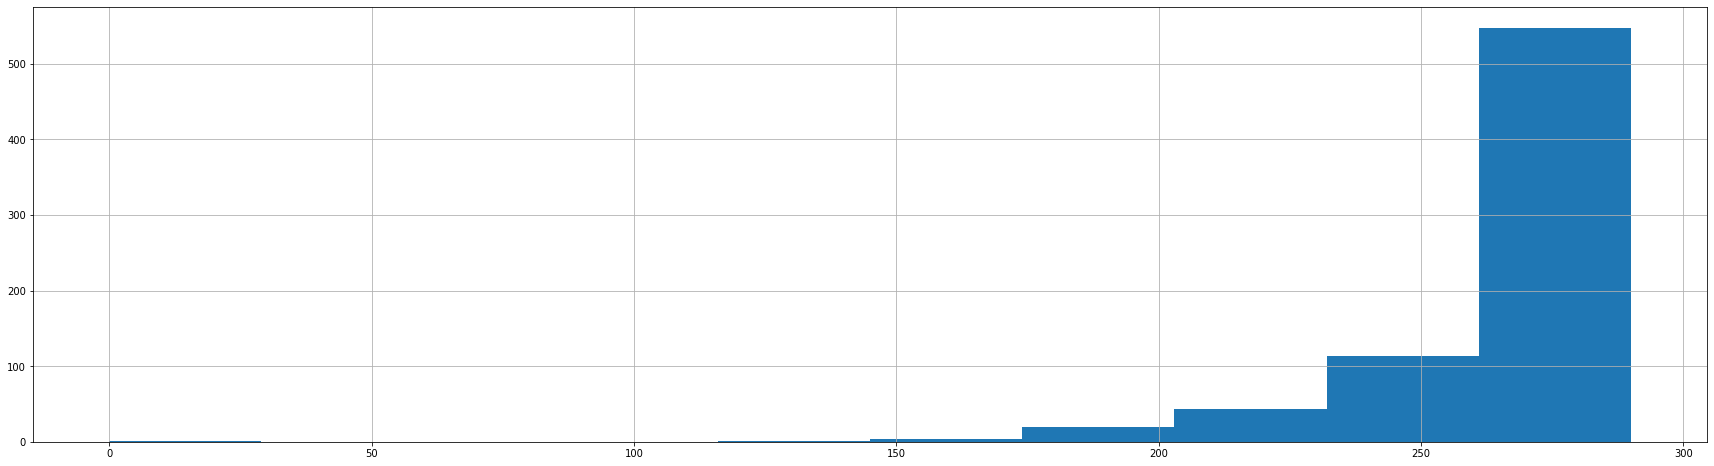

In [54]:
df.ROH.hist()
df.loc[df.ROH<150.0, 'ROH'] = df['ROH'].median()

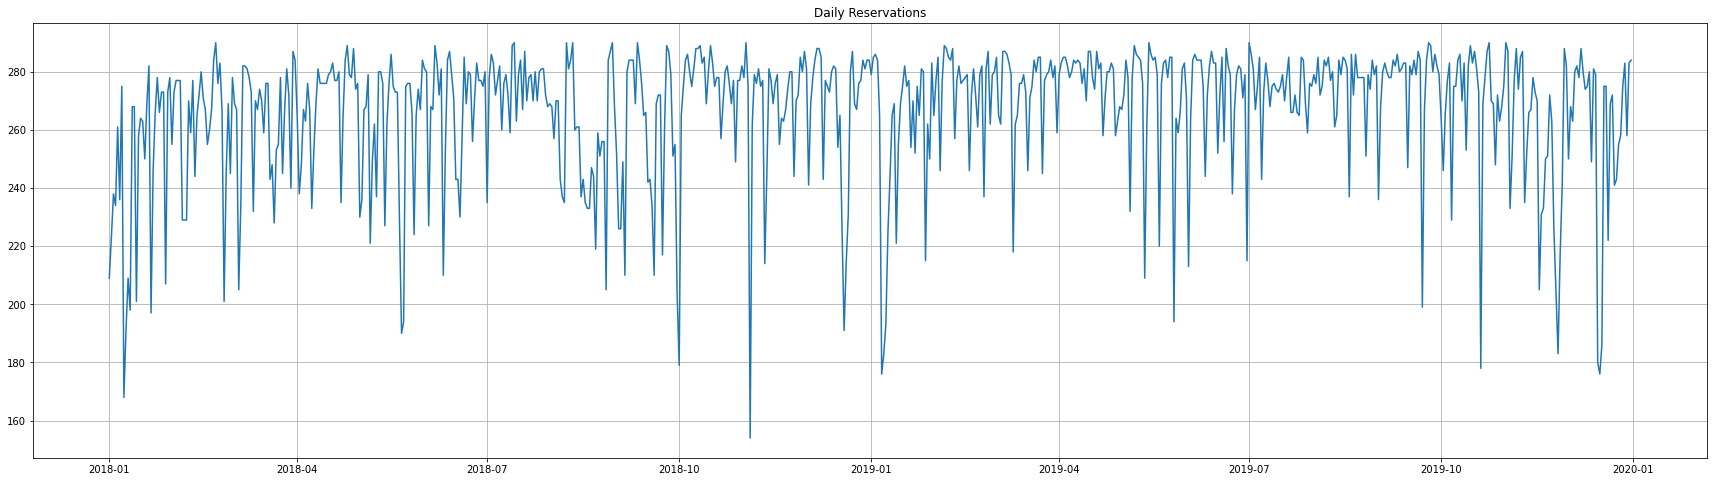

In [55]:
plt.plot(df['ROH'])
plt.title('Daily Reservations')
plt.grid(True)
plt.show()

## Averages

To make a prediction of the next point given this time series, one of the most naive method that we can use is the arithmetic average of all the previously observed data points. We take all the values we know, calculate the average and bet that that's going to be the next value. Of course it won't be it exactly, but it probably will be somewhere in the ballpark (e.g. your final school grade may be the average of all the previous grades).

\begin{align}
\hat{y}_{x+1} = \dfrac{1}{x}\sum_{i=1}^{x}y_i
\end{align}

- Where $\hat{y}_{x+1}$ refers to the predicted value at time $x + 1$

In [56]:
def average(series):
    return np.mean(series)


series = df['ROH']
average(series)

266.5753424657534

An improvement over simple arithmetic average is the average of $n$ last points. The rationale here is that only recent values matter and adding previous data points into consideration would only be adding noise. Calculation of the moving average involves what is sometimes called a "sliding window" of size $n$.

\begin{align}
\hat{y}_{x+1} = \dfrac{1}{x} \sum_{i=x - n}^{x}y_i
\end{align}

In [57]:
def moving_average(series, n):
    """Calculate average of last n observations"""
    return np.mean(series[-n:])


# prediction for the last observed day (past 24 hours)
moving_average(series, 24)

256.375

Although we can't really use this method for making predictions really far out into the future (because in order to get the value for the next step, we need the previous values to be actually observed), the moving average method can be used to smooth the original time series for spotting trend. As we'll soon see, the wider the window, the smoother the trend.

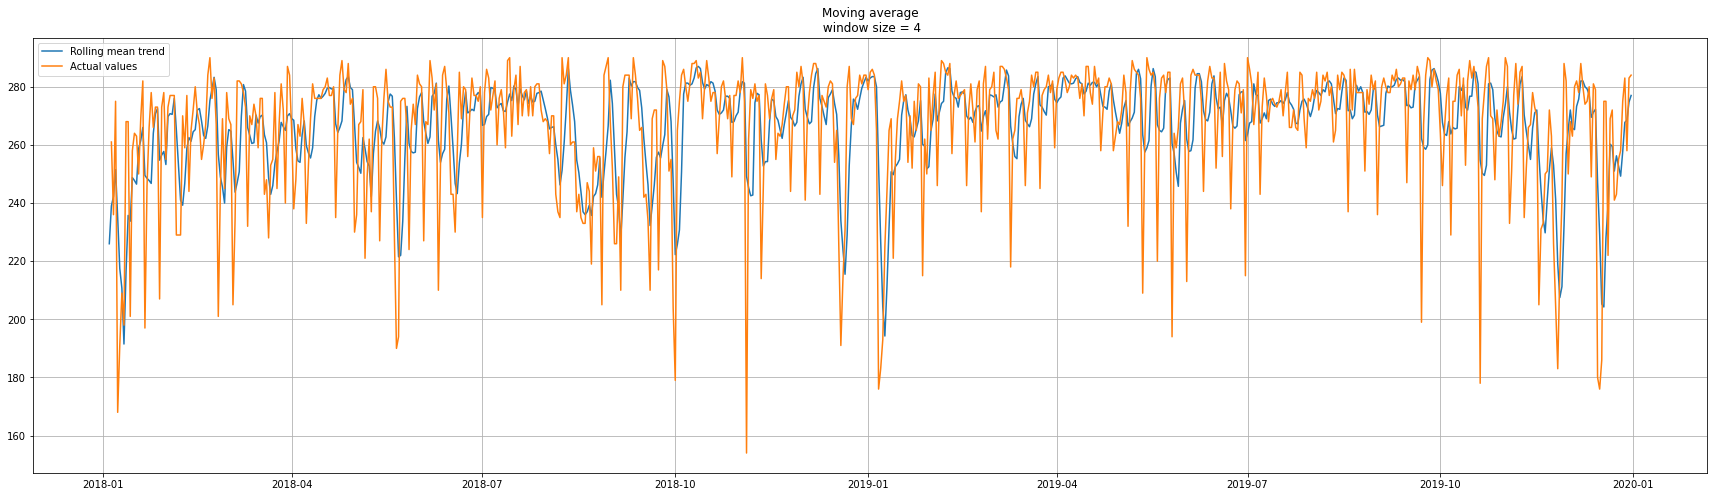

In [58]:
def plot_moving_avg(series, window):
    rolling_mean = series.rolling(window=window).mean()
    
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, label='Rolling mean trend')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)


plot_moving_avg(df, window=4)

While it might not seem that useful when we set the window size to be 4, if we were to apply the smoothing on a 24 hour window, we would get a daily trend that shows us a more interesting and perhaps expected pattern. That is: during the weekends, the values are higher (more time to play on the weekends?) while fewer ads are watched on weekdays.

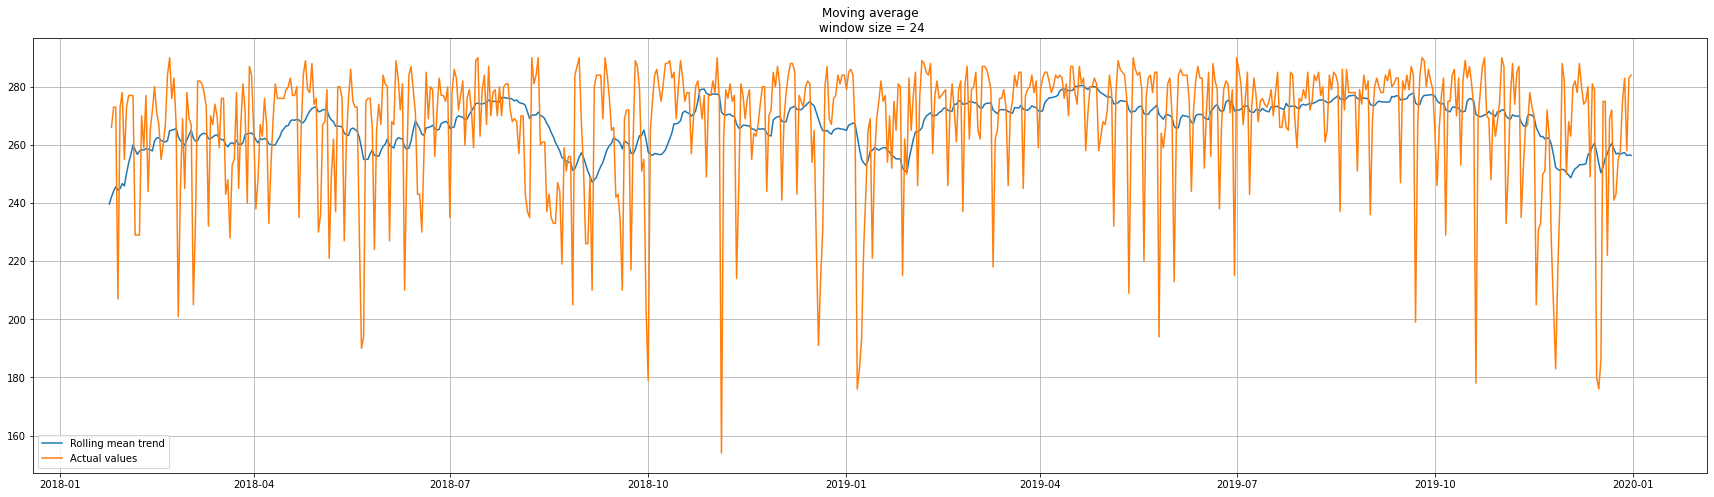

In [59]:
plot_moving_avg(df, window=24)

Side note, the following code chunk shows an implementation of moving average without using pandas' rolling functionality.

## Exponential Smoothing

Now let's see what happens if, instead of only weighting the time series' last $k$ values, we would weight all available observations while exponentially decreasing the weights as we move further back in time.

A weighted moving average is a moving average where within the sliding window values are given different weights, typically so that more recent points matter more. Instead of only weighting the time series' last $k$ values, however, we could instead consider all of the data points, while assigning exponentially smaller weights as we go back in time. This method is so called **Exponential Smoothing**. The mathematical notation for this method is:

\begin{align}
\hat{y}_x = \alpha \cdot y_x + (1 - \alpha) \cdot \hat{y}_{x-1}
\end{align}

To compute the formula, we pick an $0 < \alpha < 1$ and a starting value $\hat{y}_{0}$ (i.e. the first value of the observed data), and then calculate $\hat{y}_x$ recursively for $x = 1, 2, 3, \dots$. As we'll see in later sections, $\hat{y}_x$ is also referred to as levels.

We can think of $\alpha$ as the smoothing factor or memory decay rate, it defines how quickly we will "forget" the last available true observation. The smaller $\alpha$ is, the more influence the previous observations have and the smoother the series is. In other words, the higher the $\alpha$, the faster the method "forgets" about the past.

In [60]:
def exponential_smoothing(series, alpha):
    """given a series and alpha, return series of expoentially smoothed points"""
    results = np.zeros_like(series)

    # first value remains the same as series,
    # as there is no history to learn from
    results[0] = series[0] 
    for t in range(1, series.shape[0]):
        results[t] = alpha * series[t] + (1 - alpha) * results[t - 1]

    return results

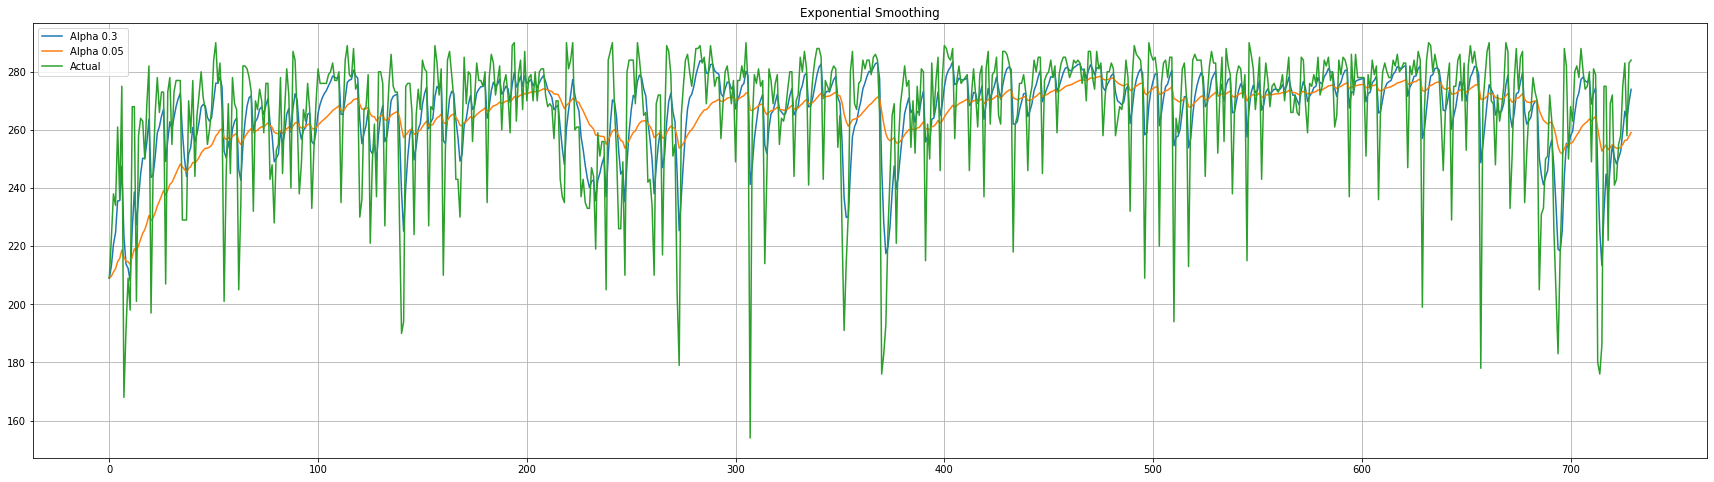

In [61]:
def plot_exponential_smoothing(series, alphas):
    """Plots exponential smoothing with different alphas."""  
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label='Alpha {}'.format(alpha))

    plt.plot(series, label='Actual')
    plt.legend(loc='best')
    plt.axis('tight')
    plt.title('Exponential Smoothing')
    plt.grid(True)


plot_exponential_smoothing(series.values, [0.3, 0.05])

Keep in mind that each series has its best $\alpha$ value. The process of finding the best $\alpha$ is referred to as fitting and we will discuss it in later section.

One very important characteristic of exponential smoothing is that remarkably, they can only forecast the current level. If we look at the formula again $\hat{y}_x = \alpha \cdot y_x + (1-\alpha) \cdot \hat{y}_{x-1}$, we can see that in order to make the prediction for $\hat{y}_x$ we also need to have the observed value $y_x$. In some other software like R, if we were to use it to predict the future, it will simply assign all future prediction the last value of the time series.

## Double Exponential Smoothing - Holt Method

The idea behind **Double Exponential Smoothing (a.k.a the Holt Method)** is exponential smoothing applied to both level and trend. The basic idea is saying if our time series has a trend, we can incorporate that information to do better than just estimating the current level and using that to forecast the future observations. To achieve this, we will introduce two new notations: the current "trend", denoted by $T$ (we can think of it as the slope of the time series), as well as the current "level", denoted by $\ell$.

To express this in mathematical notation we now need three equations: one for level, one for the trend and one to combine the level and trend to get the expected $\hat{y}$.

\begin{align}
\ell_x &= \alpha y_x + (1-\alpha)(\ell_{x-1} + T_{x-1})& \mbox{level} \nonumber \\
T_x &= \beta(\ell_x - \ell_{x-1}) + (1-\beta)T_{x-1} & \mbox{trend} \nonumber \\
\hat{y}_{x+1} &= \ell_x + T_x & \mbox{1 step forecast}\\
\end{align}

- $\ell$, level is simply predicted point. But because now it's going to be only part of calculation of the forecast (our forecast is a combination of predicted point and trend), we can no longer refer to it as $\hat{y}$
- The second equation introduces $0 < \beta< 1$, the trend coefficient. As with $\alpha$, some values of $\beta$ work better than others depending on the series. When $\beta$ is big, we won't give too much weight to the past trends when estimating current trend
- Similar to exponential smoothing, where we used the first observed value as the first expected value, we can use the first observed trend as the first expected trend, i.e. we'll use the first two points to compute the initial trend, i.e. $(y_x - y_{x-1}) / 1$.

**Side note: Additive vs Multiplicative**

Another thing to know about trend is that instead of subtracting $y_{x−1}$ from $y_x$ to estimate its initial value, we could instead divide one by the other thereby getting a ratio. The difference between these two approaches is similar to how we can say something costs $20 more or 5% more. The variant of the method based on subtraction is known as additive, while the one based on division is known as multiplicative. The additive method, is more straightforward to understand. Thus, we will stick with the additive method here. In practice, we can always try both to see which one is better.

To perform k-step-ahead forecast, we can use linear extrapolation:

\begin{align}
\hat{y}_{x+1} &= \ell_x + k T_x
\end{align}

In [62]:
def double_exponential_smoothing(series, alpha, beta, n_preds=2):
    """
    Given a series, alpha, beta and n_preds (number of
    forecast/prediction steps), perform the prediction.
    """
    n_record = series.shape[0]
    results = np.zeros(n_record + n_preds)

    # first value remains the same as series,
    # as there is no history to learn from;
    # and the initial trend is the slope/difference
    # between the first two value of the series
    level = series[0]
    results[0] = series[0]
    trend = series[1] - series[0]
    for t in range(1, n_record + 1):
        if t >= n_record:
            # forecasting new points
            value = results[t - 1]
        else:
            value = series[t]

        previous_level = level
        level = alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - previous_level) + (1 - beta) * trend 
        results[t] = level + trend

    # for forecasting beyond the first new point,
    # the level and trend is all fixed
    if n_preds > 1:
        results[n_record + 1:] = level + np.arange(2, n_preds + 1) * trend

    return results

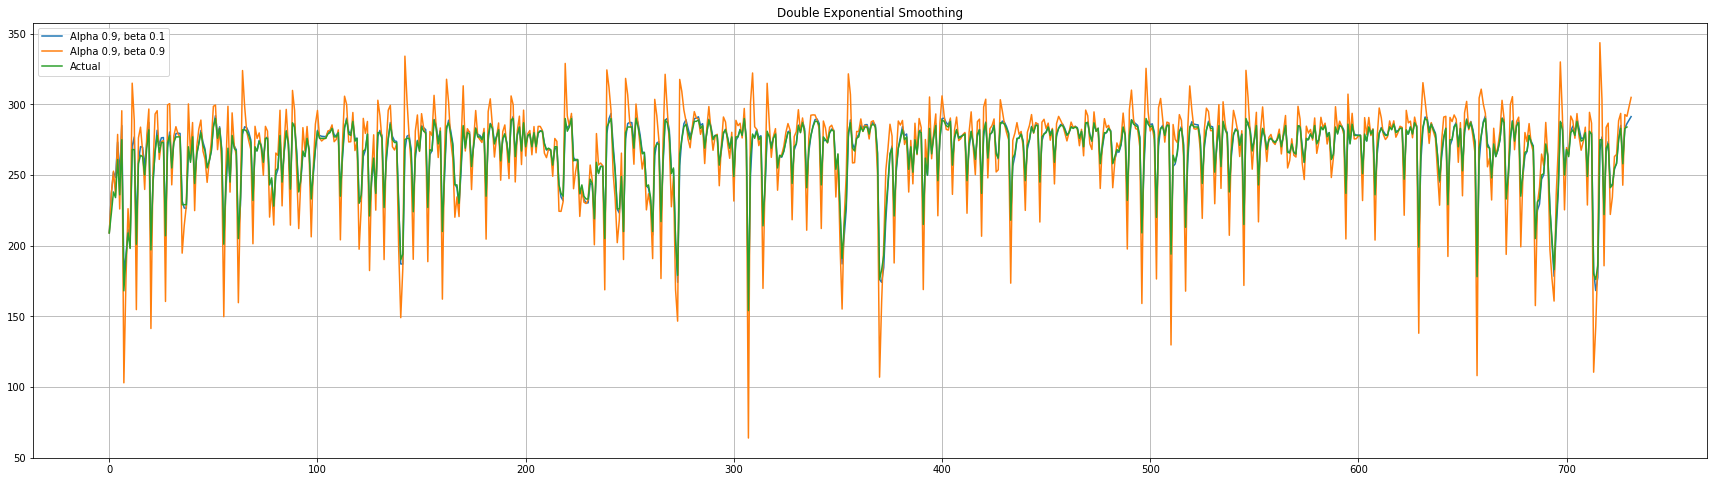

In [63]:
def plot_double_exponential_smoothing(series, alphas, betas):
    """Plots double exponential smoothing with different alphas and betas."""    
    for alpha, beta in zip(alphas, betas):
        results = double_exponential_smoothing(series, alpha, beta)
        plt.plot(results, label='Alpha {}, beta {}'.format(alpha, beta))

    plt.plot(series, label='Actual')
    plt.legend(loc='best')
    plt.axis('tight')
    plt.title('Double Exponential Smoothing')
    plt.grid(True)

plot_double_exponential_smoothing(series.values, alphas=[0.9, 0.9], betas=[0.1, 0.9])

Now we have to tune two parameters: $\alpha$ and $\beta$. The former is responsible for the series smoothing around the trend, the latter for smoothing the trend itself. Again, the larger the values for these parameters, the more weight recent observations will carry and the less smooth the modeled series will be.

Although this method can now predictive future values, if we stare closer at the forecast formula $\hat{y}_{x+1} = \ell_x + k T_x$, we can see that once the trend ($T$) is estimated to be positive, all future predictions can only go up from the last value in the time series. On the other hand, if the trend ($T$) is estimated to be negative, all future predictions can only go down. This property makes this method unsuitable for predicting very far out into the future as well. With that in mind, let's now turn towards triple exponential smoothing.

## Triple Exponential Smoothing - Holt-Winters Method

The idea behind **triple exponential smoothing (a.k.a Holt-Winters Method)** is to apply exponential smoothing to a third component - seasonality, $S$. This means we should not be using this method if our time series is not expected to have seasonality.

This seasonal components in the model will explain repeated variations around intercept and trend, and it will be specified by the length of the season, in other words, by the period which the variations repeats itself. To elaborate, for each observation in the season, there will be a separate component. For example, if the length of the season is 7 days (a weekly seasonality), we will have 7 seasonal components, one for each day of the week. Then the seasonal component of the 3rd point into the season would be exponentially smoothed with the 3rd point of last season, 3rd point two seasons ago, etc. In mathematical notation, we now have four equations:

\begin{align}
\ell_x &= \alpha(y_x - S_{x-L}) + (1-\alpha)(\ell_{x-1} + T_{x-1})& \mbox{level} \nonumber \\
T_x &= \beta(\ell_x - \ell_{x-1}) + (1-\beta) T_{x-1} & \mbox{trend} \nonumber \\
S_x &= \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L} & \mbox{seasonal} \nonumber \\
\hat{y}_{x+m} &= \ell_x + m T_x + S_{x-L+1+ \text{ (m-1) mod L}} & \mbox{forecast}\\
\end{align}

- Season length is the number of data points after which a new season begins. We will use $L$ to denote season length.
- Note that when estimating the level $\ell_x$, we subtract the estimated seasonality from $y_x$. The trend part remains the same and when estimating the seasonality $S_x$, we subtract the estimated level, $\ell_x$, from it.
- We now have a third coefficient, $0 < \gamma < 1$, which is the smoothing factor for the seasonal component.
- The index for the forecast, $\hat{y}_{x+m}$, is $x+m$ where $m$ can be any integer. Meaning we can forecast any number of points into the future while accounting for previous value, trend and seasonality.
- The index of the seasonal component of the forecast $S_{x-L+1+(m-1)modL}$ may appear a little mind boggling, but as we'll soon see in the implementation, this is essentially offsetting into our observed data's list of seasonal components. e.g. if we are forecasting the 3rd point into the season, and we are 45 seasons into the future, we cannot use seasonal components from the 44th season in the future since that season is also generated by our forecasting procedure, we must use the last set of seasonal components from observed points, or from "the past" if you will.

**Initial Trend Component:**

Back when we introduced the double exponential smoothing method, we were required to provide an estimate of the initial trend for the model. The same applies for triple exponential smoothing. Except, with seasonal data we can do better than using the first two points to estimate the initial trend. The most common practice here is to compute the average trend averages across seasons.

\begin{align}
T_0 = \dfrac{1}{L}\left(\dfrac{y_{L+1}-y_1}{L}+\dfrac{y_{L+2}-y_2}{L}+...+\dfrac{y_{L+L}-y_L}{L}\right)
\end{align}

In [64]:
def initial_trend(series, season_len):
    total = 0.0
    for i in range(season_len):
        total += (series[i + season_len] - series[i]) / season_len

    trend = total / season_len
    return trend


# we have a daily seasonality, which
# means our season length is 24 (the time
# interval in our time series is measured in hours)
season_len = 24
initial_trend(series, season_len)

0.9097222222222223

**Initial Seasonal Components:**

The situation is slightly more complicated when it comes to providing initial values for seasonal components. Briefly, we need to compute the average level for every observed season we have, then subtract every observed value by the average for the season it's in and finally average each of these numbers across our observed seasons. We'll will forgo the math notation for the initial seasonal components. The following link contains a step-by-step walk-through of this process if interested. [Notes: Triple Exponential Smoothing](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm)

In [65]:
# given that we've defined the length for
# our season, we can figure out how many
# seasons are there in our time series
# and we need to compute the average values
# for each season
n_seasons = len(series) // season_len

season_averages = np.zeros(n_seasons)
for j in range(n_seasons):
    start_index = season_len * j
    end_index = start_index + season_len
    season_average = np.sum(series[start_index:end_index]) / season_len
    season_averages[j] = season_average

season_averages

array([239.66666667, 261.5       , 262.70833333, 262.20833333,
       272.95833333, 255.04166667, 265.58333333, 271.625     ,
       274.20833333, 251.83333333, 260.83333333, 267.58333333,
       270.54166667, 268.16666667, 265.125     , 259.08333333,
       270.29166667, 274.33333333, 271.54166667, 280.        ,
       270.75      , 270.04166667, 273.45833333, 272.375     ,
       276.91666667, 275.66666667, 273.08333333, 269.91666667,
       251.58333333, 259.20833333])

In [66]:
# estimate the initial seasonal components
seasonals = np.zeros(season_len)
seasons = np.arange(n_seasons)
index = seasons * season_len
for i in range(season_len):
    seasonal = np.sum(series[index + i] - season_averages) / n_seasons
    seasonals[i] = seasonal

seasonals

array([-1.32777778,  1.37222222,  0.23888889,  3.23888889,  7.87222222,
        2.27222222, -0.36111111, -3.02777778, -1.59444444, -5.06111111,
        0.60555556,  1.03888889,  1.57222222, -0.96111111,  0.07222222,
       -0.22777778, -0.92777778, -3.46111111,  1.53888889, -1.46111111,
       -0.22777778, -1.76111111, -2.02777778,  2.60555556])

In [67]:
class HoltWinters:
    """Scikit-learn like interface for Holt-Winters method."""

    def __init__(self, season_len=24, alpha=0.5, beta=0.5, gamma=0.5):
        self.beta = beta
        self.alpha = alpha
        self.gamma = gamma
        self.season_len = season_len

    def fit(self, series):
        # note that unlike scikit-learn's fit method, it doesn't learn
        # the optimal model paramters, alpha, beta, gamma instead it takes
        # whatever the value the user specified the produces the predicted time
        # series, this of course can be changed.
        beta = self.beta
        alpha = self.alpha
        gamma = self.gamma
        season_len = self.season_len
        seasonals = self._initial_seasonal(series)

        # initial values
        predictions = []
        smooth = series[0]
        trend = self._initial_trend(series)
        predictions.append(smooth)

        for i in range(1, len(series)):
            value = series[i]
            previous_smooth = smooth
            seasonal = seasonals[i % season_len]
            smooth = alpha * (value - seasonal) + (1 - alpha) * (previous_smooth + trend)
            trend = beta * (smooth - previous_smooth) + (1 - beta) * trend
            seasonals[i % season_len] = gamma * (value - smooth) + (1 - gamma) * seasonal
            predictions.append(smooth + trend + seasonals[i % season_len])

        self.trend_ = trend
        self.smooth_ = smooth
        self.seasonals_ = seasonals
        self.predictions_ = predictions
        return self
    
    def _initial_trend(self, series):
        season_len = self.season_len
        total = 0.0
        for i in range(season_len):
            total += (series[i + season_len] - series[i]) / season_len

        trend = total / season_len
        return trend

    def _initial_seasonal(self, series):
        season_len = self.season_len
        n_seasons = len(series) // season_len

        season_averages = np.zeros(n_seasons)
        for j in range(n_seasons):
            start_index = season_len * j
            end_index = start_index + season_len
            season_average = np.sum(series[start_index:end_index]) / season_len
            season_averages[j] = season_average

        seasonals = np.zeros(season_len)
        seasons = np.arange(n_seasons)
        index = seasons * season_len
        for i in range(season_len):
            seasonal = np.sum(series[index + i] - season_averages) / n_seasons
            seasonals[i] = seasonal

        return seasonals

    def predict(self, n_preds=10):
        """
        Parameters
        ----------
        n_preds: int, default 10
            Predictions horizon. e.g. If the original input time series to the .fit
            method has a length of 50, then specifying n_preds = 10, will generate
            predictions for the next 10 steps. Resulting in a prediction length of 60.
        """
        predictions = self.predictions_
        original_series_len = len(predictions)
        for i in range(original_series_len, original_series_len + n_preds):
            m = i - original_series_len + 1
            prediction = self.smooth_ + m * self.trend_ + self.seasonals_[i % self.season_len]
            predictions.append(prediction)

        return predictions

## Time Series Cross Validation

Before we start building this model, let's take a step back and first discuss how to estimate model parameters automatically.

As always, we have to choose a loss function suitable for the task that will tell us how closely the model approximates the underlying pattern. Then, using cross-validation, we will evaluate our chosen loss function for the given model parameters. The only minor difference, compared with standard supervised learning methods is the way to perform cross validation. Because time series data have this temporal structure, one cannot randomly mix values in a fold while preserving this structure. With randomization, all the time dependencies between observations will be lost, hence the cross validation method that we'll be using will be based on a rolling window approach.

The idea is -- we train our model on a small segment of the time series from the beginning until some time $t$, make predictions for the next $t+n$ steps, and calculate an error. Then, we expand our training sample to $t+n$ value, make predictions from $t+n$ until $t+2∗n$, and continue moving our test segment of the time series until we hit the last available observation.

<img src="img/time_series_cv.png" width="60%" height="60%">

Apart from setting up our cross validation, we also need an numerical optimization algorithm to learn our Holt-Winters model's parameters $\alpha$, $\beta$ and $\gamma$. For this model, as well as in other exponential smoothing methods, there's a constraint on how large the smoothing parameters can be, each of them ranging from 0 to 1. Therefore, in order to minimize our loss function, we have to choose an algorithm that supports constraints on model parameters. In our case, we will use the truncated Newton conjugate gradient (we'll use scipy's `minimize` function to achieve this, instead of going into the details of this optimization algorithm as this is not the focus of this documentation).

The next couple of code chunks, sets up the cross validation, uses the numerical optimization algorithm to learn the optimal parameter and plots the predicted time series versus the original.

## Learning Holt-Winters Method's Parameters

In [68]:
def timeseries_cv_score(params, series, loss_function, season_len=24, n_splits=3):
    """
    Iterating over folds, train model on each fold's training set,
    forecast and calculate error on each fold's test set.
    """
    errors = []    
    alpha, beta, gamma = params
    time_series_split = TimeSeriesSplit(n_splits=n_splits) 

    for train, test in time_series_split.split(series):
        model = HoltWinters(season_len, alpha, beta, gamma)
        model.fit(series[train])

        # evaluate the prediction on the test set only
        predictions = model.predict(n_preds=len(test))
        test_predictions = predictions[-len(test):]
        test_actual = series[test]
        error = loss_function(test_actual, test_predictions)
        errors.append(error)

    return np.mean(errors)

In [69]:
# provide initial values for model parameters' alpha, beta and gamma
# and leave out the last 20 points of our time series as test set
x = [0, 0, 0]
test_size = 20
n_splits=3
data = series.values[:-test_size]
opt = minimize(timeseries_cv_score, x0=x, args=(data, mean_squared_log_error,n_splits), method='TNC', bounds=((0, 1), (0, 1), (0, 1)))

print('original parameters: {}'.format(str(x)))
print('best parameters: {}'.format(str(opt.x)))

original parameters: [0, 0, 0]
best parameters: [0.03058547 0.03892989 0.        ]


In [70]:
# retrieve optimal values, train the finnal model with them
# and generating forecast for next 50 hours
alpha_final, beta_final, gamma_final = opt.x
model = HoltWinters(season_len, alpha_final, beta_final, gamma_final)
model.fit(data)
predictions = model.predict(n_preds=50)

print('original series length: ', len(series))
print('prediction length: ', len(predictions))

original series length:  730
prediction length:  760


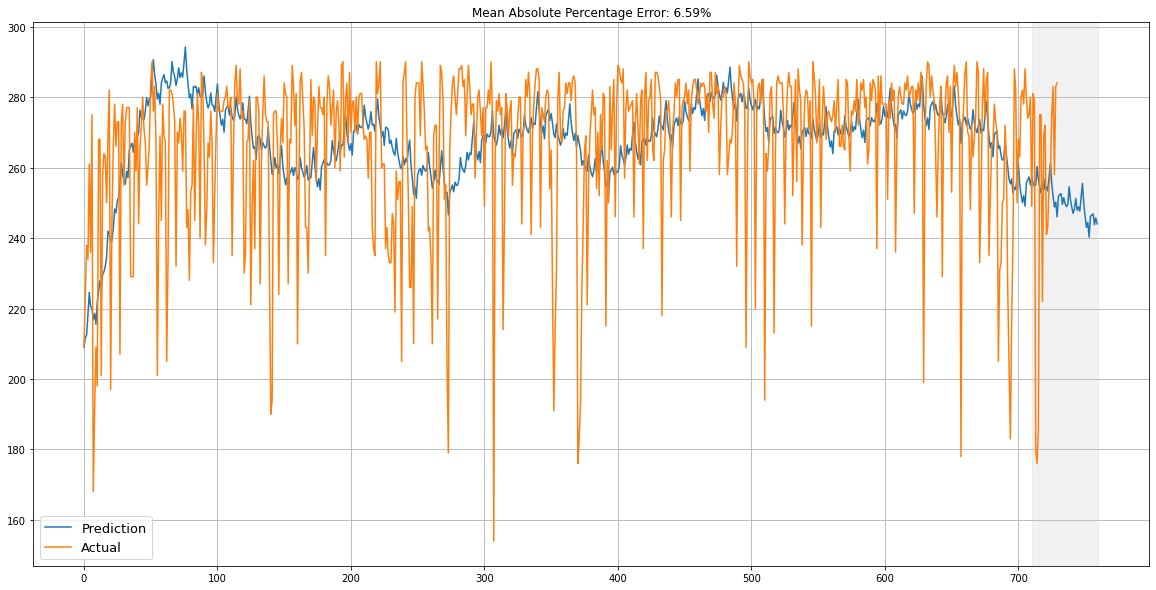

In [71]:
# more on this evaluation metric in the section below
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


data = series.values
error = mean_absolute_percentage_error(data, predictions[:len(series)])

plt.figure(figsize=(20, 10))
plt.plot(predictions, label='Prediction')
plt.plot(data, label='Actual')
plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
plt.axvspan(len(series) - test_size, len(predictions), alpha=0.3, color='lightgrey')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='best', fontsize=13)
plt.show()

Judging by the plot, our model was able to approximate the initial time series, capturing the daily seasonality, overall downwards trend. We've also used an evaluation metric called **MAPE (Mean Absolute Percentage Error)**:

\begin{align}
MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{\big| y_i - \hat{y}_i \big|}{y_i}
\end{align}

Mean Absolute Percentage Error measures the size of our model's absolute error (the absolute difference between our model's prediction versus the actual number) when compared with the original value.

**Pros:**

- This is a preferable metric because most people are comfortable thinking in terms of percentage. e.g. When predicting an item's demand volume, it might be more interpretable to tell our manager that the prediction is off by less than 4% rather than saying we're off by 3,000 items if the manager doesn't know what's the typical demand for this item.

**Cons:**

- The percentage interpretation is a double-edged sword. Looking at the formula of the evaluation metric, we can see that the actual observed data's number is in the denominator of the equation. Meaning this value is actually not defined when the actual value is zero. And the actual caveat is when the actual value is really small, then MAPE will often take on extremely large values, rendering it unstable for low-volume data.

Apart from MAPE, some other evaluation metrics that are commonly used in the field of forecasting are **Mean Absolute Error** and **Median Absolute Error**, where both metric retains the original time series' measurement unit, and median absolute error makes the metric more robust to outliers.

This concludes our discussion with Additive Exponential Smoothing methods, for readers interested, the following link contains resources that introduces both additive and multiplicative methods. [Online Book: Forecasting Principle and Practices - Exponential smoothing](https://www.otexts.org/fpp/7)

# Reference

- [Blog: Holt-Winters Forecasting for Dummies (or Developers) - Part I](https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/)
- [Blog: Holt-Winters Forecasting for Dummies - Part II](https://grisha.org/blog/2016/02/16/triple-exponential-smoothing-forecasting-part-ii/)
- [Blog: Holt-Winters Forecasting for Dummies - Part III](https://grisha.org/blog/2016/02/17/triple-exponential-smoothing-forecasting-part-iii/)
- [Blog: How To Backtest Machine Learning Models for Time Series Forecasting](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)
- [Blog: Forecasting 101: A Guide to Forecast Error Measurement Statistics and How to Use Them](https://www.forecastpro.com/Trends/forecasting101August2011.html)
- [Jupyter Notebook: Open Machine Learning Course - Time series analysis in Python](http://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic09_time_series/topic9_part1_time_series_python.ipynb)